In [2]:
#KONVOLUCNI NEURONOVA SIT Andrej Polyak

###PRIPRAVA TRENOVACICH DAT
#1,dve ruzne skupiny A:kocky B:psy

import os
import cv2
import numpy as np
from tqdm import tqdm
#Import Knihoven



##1,Jako trenovaci data jsem pouzil Dogs vs Cats dataset od microsoftu 



REBUILD_DATA = False # True pro prvni trenovani jinak false pokud nechci menit trenovaci data

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0
#RESIZE TRENOVACICH DAT NA 50x50 

###>>Snazim se opakovane projit adresar kocek a psu, uchopit obrazek zmenit mu velikost
### a prevest tridy kocek a psu (kocky=0,psy=1) a potom na trenovaci data<<
    

#***Prochazeni adresaru kocek a psu a prohlizeni vsech obrazku***#
    def make_training_data(self): ## Vytvoreni nove metody "make_training_data"
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
#***Prochazeni adresaru kocek a psu a prohlizeni vsech obrazku***#




##***Prosel jsem data, prevedl je na sedoton, resizel je. 
##***Data v podobe cisel (kocky=0,psy=1) + obrazova data pridana do skupiny training_data
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) ###eye prevod matice na vektor 2d>1d
                        
                        ###***Vypocet vah pro klasifikaci***###
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                        ###***Vypocet vah pro klasifikaci***###

                    except Exception as e:# Nektere obrazky nejsou vhodne, vyhnuti erroru
                        pass
##***Prosel jsem data, prevedl je na sedoton, resizel je. 
##***Data v podobe cisel (kocky=0,psy=1) + obrazova data pridana do skupiny training_data
                        

        
###***Zamichani trenovacicih dat***###      
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)
###***Zamichani trenovacicih dat***###  


if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


training_data = np.load("training_data.npy", allow_pickle=True)##Trenovaci dat jednou natrenovat a dost!
print(len(training_data))


24946


In [3]:
###STAVBA KONVOLUCNI NEURONOVE SITE
###Import knihoven
import torch
import torch.nn as nn
import torch.nn.functional as F



In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()#METODY
        
        ###***2D Konvolucni vrstvy pro 2D obrazek***###
        self.conv1 = nn.Conv2d(1, 32, 5) # vstup je 1 obrazek, 32 transformovany vystup, 5x5 konvolucni jadro
        self.conv2 = nn.Conv2d(32, 64, 5)# vtsup 32, vystup 64, konvolucni jadro 5x5
        self.conv3 = nn.Conv2d(64, 128, 5)#vstup 64, vystup 128, konvolucni jadro 5x5
        ###***2D Konvolucni vrstvy pro 2D obrazek***###

        ###Pracuji s pytrochem a potrebuji mit linearni vrstvy jako rozdeleni predpovedi
        ###***Prevod vrstev na linearni (ze spiraly zplosteni do linearity)***###
        x = torch.randn(50,50).view(-1,1,50,50)#falesny tensor(data), ktery se posila do neuronky bude mit tenhle tvar (-1,1,50,50) 
        self._to_linear = None #kdykoliv inicializuji vytvorim nahodna data
        self.convs(x)#predam nahodna data x, tyto nahodna data jsou soucasti realnych z konvolucnich vrstev
        
        
        #2 LINEARNI VRSTVY **ke sjednoceni "self._to_linear" chytit rozmery tensoru a znasobit je
        ##pytroch nema zplostovaci funkci jako napriklad keras
        ### proto se musi vyrovnat vystup z posledni vrstvy nez projedou pravou vrstvou v pytrochi "linearni".
        self.fc1 = nn.Linear(self._to_linear, 512)# vstup je object "self._to_linear" z funkce nize ,vystup 512 hustych vrstev 
        self.fc2 = nn.Linear(512, 2) # 512 vstup, vystup 2 (kocky,psi)
        ###***Prevod vrstev na linearni (ze spiraly zplosteni do linearity)***###
        
        
        ###***Funkce: znasobeni linearniho a konvolucniho vystupu***#
    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))#kopie pravidelne konvolucni vrtsvy,linearni data na konvolucnich vrstvach,potom okno 2x2
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        #print(x[0].shape)##je potreba jednou zachtit pro napojeni na hlavni tvar

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]#pridani tvaru do vystupu z prave vrstvy pomoci nasobeni 
        return x

    def forward(self, x):
        x = self.convs(x)# vsechny konvolucni vrstvy
        x = x.view(-1, self._to_linear)  # zaplnovani daty (tvaru) objektu "self._to_linear"
        x = F.relu(self.fc1(x))#poslem to do linarni vrstvy 
        x = self.fc2(x) # finalni linearni vrstva
        return F.softmax(x, dim=1)#aktivacni funkce


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
### TRENOVANI KONVOLUCNI NERONOVE SITE #####


##Import optimalizatoru pro trenovani koncolucni neuronove site

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()#stredni chyba na druhou

In [6]:
###Odedeleni y od X (tensoru) z trenovacich dat (falesne prave)

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0#potrebuji pixely 0-1 ne 0-255
y = torch.Tensor([i[1] for i in training_data])

In [7]:
##Oddeleni trenovacich a testovacich dat

VAL_PCT = 0.1  # 10% trenovacich dat
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [8]:
###Trenovaci a testovaci data

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [10]:
print(len(train_X), len(test_X))

22452 2494


In [11]:
###Trenovani neuronky 3 periody po 100 davkach dat

BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.2473745346069336


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.23817740380764008


100%|██████████| 225/225 [01:52<00:00,  2.00it/s]

Epoch: 2. Loss: 0.17594939470291138


In [12]:
### presnost 70% po 3 epochah je dobra kdyz jsou data rozdelena skoro 50/50

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:06<00:00, 378.87it/s]

Accuracy:  0.721


In [13]:
print(training_data[1])

[array([[ 29,  26,  28, ..., 107, 149, 185],
       [ 20,  24,  18, ..., 125,  23, 217],
       [ 21,  17,  16, ..., 122,  21, 246],
       ...,
       [ 15,  13,   9, ...,  58,  55,  51],
       [ 15,  11,  12, ...,  52,  52,  57],
       [ 10,  10,  12, ...,  49,  52,  51]], dtype=uint8)
 array([1., 0.])]


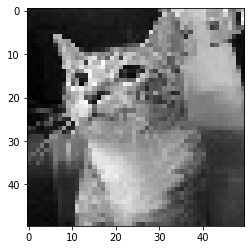

In [14]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()